In [5]:
import sys, importlib, time
sys.path.append('../../')

from src.Modules.Utils.Imports import *
from src.Modules.Models.BuildBINNs import BINN
from src.Modules.Utils.ModelWrapper import ModelWrapper
from src.Modules.Utils.Gradient import Gradient

import src.Modules.Utils.PDESolver as PDESolver
import src.Modules.Loaders.DataFormatter as DF

from src.DE_simulation import fickian_diffusion, Diffusion_eqn, simple_pulling_diffusion, simple_adhesion_diffusion, Heterogeneous_Diffusion_eqn
from scipy.integrate import odeint
from scipy.stats import qmc
from scipy.interpolate import RBFInterpolator
import matplotlib.patches as mpatches
from get_params import get_pulling_params, get_adhesion_params, get_heterog_params
device = torch.device(GetLowestGPU(pick_from=[0,1,2,3]))

# helper functions
def to_torch(x):
    return torch.from_numpy(x).float().to(device)
def to_numpy(x):
    return x.detach().cpu().numpy()

def load_model(binn_name, x, t, save_name):

    # instantiate BINN
    binn = BINN(binn_name,x, t).to(device)
    weight = '_best_val'
    
    # wrap model and load weights
    parameters = binn.parameters()
    model = ModelWrapper(
        model=binn,
        optimizer=None,
        loss=None,
        save_name=save_name)
    
    #model.save_name += '_' + binn.name + weight
    model.save_name += weight
    model.load(model.save_name + '_model', device=device)

    return model, binn


def recover_binn_params(binn):
    # learned diffusion term
    def D(u):
        D = binn.diffusion(to_torch(u)[:, None])
        return to_numpy(D).reshape(-1)

    # learned growth term
    def G(u):
        r = binn.growth(to_torch(u)[:, None])
        return to_numpy(r).reshape(-1)  

    return D, G


def DE_sim(x, t, q, IC, Diffusion_function, PDE_type = "1d"):
    
    if PDE_type == "1d":
        sol = odeint(Diffusion_eqn, IC, t, args=(x, q, Diffusion_function))
    elif PDE_type == "heterogeneous":
        sol = odeint(Heterogeneous_Diffusion_eqn, IC, t, args=(x, q))
        sol = sol[:, :len(x)] + sol[:, len(x):]
    sol = sol.T
    
    return sol

            
path = '../../data/'

### BINN model information
save_folder = "../../Weights/"
model_name = 'DMLP'
weight = '_best_val'
pde_weight = 1e4

Pp = 0.0

def BINN_Diffusion_mesh_generate_fixed_Pm(u_mesh,Pints,scenario,Pm=1.0):
    
    D_mesh = []
    filename_header = f"simple_{scenario}_mean_25"
    
    #Create mesh of D^{MLP} from computed Padh, Pm values
    for Pint in Pints:

        if scenario == "pulling":
            file_name = f'{filename_header}_Pm_{Pm}_Pp_{Pp}_Ppull_{Pint}'    
        elif scenario == "adhesion":
            file_name = f'{filename_header}_Pm_{Pm}_Pp_{Pp}_Padh_{Pint}'    

        binn_name  = f"{model_name}"
        try:
            save_name =  f"BINN_training_{binn_name}_{file_name}_pde_weight_{pde_weight}"
            model,binn = load_model(binn_name=binn_name,save_name=save_folder + save_name,x=1.0,t=1.0)
        except:
            save_name =  f"BINN_training_{binn_name}_{file_name}_perc_0.75_pde_weight_{pde_weight}"
            model,binn = load_model(binn_name=binn_name,save_name=save_folder + save_name,x=1.0,t=1.0)

        # evaluate parameter networks
        D_mesh_tmp = to_numpy(binn.diffusion(to_torch(u_mesh)[:, None]))
        D_mesh.append(np.squeeze(D_mesh_tmp))
    
    return np.array(D_mesh).T
def BINN_Diffusion_mesh_generate(u_mesh,Pints,Pms,scenario):
    
    D_mesh = []
    filename_header = f"simple_{scenario}_mean_25"
    
    #Create mesh of D^{MLP} from computed Padh, Pm values
    for Pm in Pms:
        
        D_mesh_Padh_u = []
        
        for Pint in Pints:

            if scenario == "pulling":
                file_name = f'{filename_header}_Pm_{Pm}_Pp_{Pp}_Ppull_{Pint}'    
            elif scenario == "adhesion":
                file_name = f'{filename_header}_Pm_{Pm}_Pp_{Pp}_Padh_{Pint}'    

            binn_name  = f"{model_name}"
            try:
                save_name =  f"BINN_training_{binn_name}_{file_name}_pde_weight_{pde_weight}"
                model,binn = load_model(binn_name=binn_name,save_name=save_folder + save_name,x=1.0,t=1.0)
            except:
                save_name =  f"BINN_training_{binn_name}_{file_name}_perc_0.75_pde_weight_{pde_weight}"
                model,binn = load_model(binn_name=binn_name,save_name=save_folder + save_name,x=1.0,t=1.0)

            # evaluate parameter networks
            D_mesh_Padh_u_tmp = to_numpy(binn.diffusion(to_torch(u_mesh)[:, None]))
            D_mesh_Padh_u.append(np.squeeze(D_mesh_Padh_u_tmp))
        
        D_mesh.append(D_mesh_Padh_u)
    
    return np.array(D_mesh).T 

def Interpolated_PDE_simulation(Pint, Pm, f, scenario):
    
    filename_header = f"simple_{scenario}_mean_25"
    
    def interpolated_diffusion(u):
        U, PINT, PM = np.meshgrid( u , Pint, Pm, indexing = "ij")
        shape = U.shape
        new_points = np.array(list(zip(U.reshape(-1), 
                                       PINT.reshape(-1) )))
        D_mesh_new = f(new_points).reshape(shape)[:,0,0]
        D_mesh_new[D_mesh_new < 0] = 0
        return D_mesh_new

    x = np.arange(200)
    t = np.linspace(0,1000,100)
    IC = .75*np.logical_and(x>80, x<120)

    t0 = time.time()
    sol = DE_sim(x, 
                 t, 
                 [], 
                 IC, 
                 Diffusion_function = interpolated_diffusion)    
    tf = time.time()-t0
    
    if scenario == "pulling":
        file_name = f'{filename_header}_Pm_{Pm}_Pp_{Pp}_Ppull_{Pint}' 
    elif scenario == "adhesion":
        file_name = f'{filename_header}_Pm_{Pm}_Pp_{Pp}_Padh_{Pint}' 
        
    try:
        inputs, outputs, shape  = DF.load_ABM_data(path+file_name+"_perc_0.75.npy",plot=False)
    except:
        inputs, outputs, shape  = DF.load_ABM_data(path+file_name+".npy",plot=False)

    x,t = unique_inputs(inputs)

    U = outputs.reshape((len(x),-1))
    
    #plot_DEs_against_data(x,t,U, sol)
    
    return sol, tf

def plot_DEs_against_data(x, t, U, sol_binn, suptitle=None, filename=None):
    
    assert (len(x) == U.shape[0])
    assert (len(t) == U.shape[1])
    assert (U.shape == sol_binn.shape)
    
    fig, axes = plt.subplots(2,3,figsize=(8,10))
    axes = axes.reshape(-1)

    fontsize=18
    
    count = 0
    for i in np.linspace(0,len(t)-1,5,dtype=int):
        axes[count].plot(x[::4],U[::4,i],"o",color="black",markersize=7)
        #axes[count].plot(x,sol[:,i],"-",linewidth=2)
        axes[count].plot(x,sol_binn[:,i],"--",linewidth=2)

        axes[count].set_xlabel("Space (mm)",fontsize=fontsize)
        axes[count].set_ylabel("Density (normalized)",fontsize=fontsize)
        count+=1
        #axes[count].set_xlim([0,20])
        axes[count].set_ylim([0,0.9])
    
    if suptitle is not None:
        plt.suptitle(suptitle)
    if filename is not None:
        if filename[-4:] == ".pdf":
            plt.savefig(filename)
        else:
            plt.savefig(filename+".pdf")
            
def unique_inputs(inputs):
    x = np.unique(inputs[:,0])
    t = np.unique(inputs[:,1])
    return x,t
            

Device set to cpu


In [3]:
path = '../../data/'

### BINN model information
save_folder = "../../Weights/"
model_name = 'DMLP'
weight = '_best_val'
pde_weight = 1e4

Pp = 0.0


## Pulling model

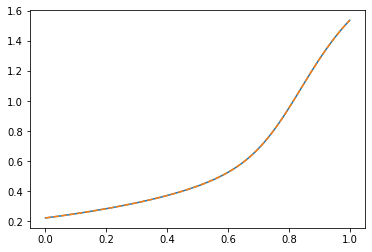

In [45]:
Pm = 1.0 
Ppulls = np.round(np.linspace(0.0,1.0,11),2)

i = 10
Pint = Ppulls[i]
def interpolated_diffusion(u):
    U, PINT, PM = np.meshgrid( u , Pint, Pm, indexing = "ij")
    shape = U.shape
    new_points = np.array(list(zip(U.reshape(-1), 
                                   PINT.reshape(-1) )))
    D_mesh_new = f(new_points).reshape(shape)[:,0,0]
    D_mesh_new[D_mesh_new < 0] = 0
    return D_mesh_new


plt.plot(u_mesh, D_mesh[:,i])
plt.plot(u_mesh, interpolated_diffusion(u_mesh),"--" )

In [53]:
scenario = "pulling"
filename_header = f"simple_{scenario}_mean_25"

Pms = np.array([1.0])
Ppulls = np.round(np.linspace(0.0,1.0,11),2)

u_mesh = np.linspace(0, 1, 101)
U_mesh, Ppull_mesh = np.meshgrid(u_mesh , Ppulls, indexing = "ij")
shape = U_mesh.shape

D_mesh = np.squeeze(BINN_Diffusion_mesh_generate(u_mesh, Ppulls, Pms, scenario))

sampled_points = np.array(list(zip(U_mesh.reshape(-1), 
                                 Ppull_mesh.reshape(-1) )))

f = RBFInterpolator(sampled_points, D_mesh.reshape(-1))

Pm = 1.0
for Ppull_tmp in Ppulls:
    print(f"Ppull vary:{Ppull_tmp}")
    sol, cpu_time = Interpolated_PDE_simulation(Ppull_tmp, Pm, f, scenario)

    filename_head_params = f'{filename_header}_Pm_{Pm}_Pp_{Pp}_Ppull_{Ppull_tmp}'
    save_filename = f"../../results/timing/Interpolated_PDE_sim_{filename_head_params}"

    data = {}
    data['time'] = cpu_time
    np.save(save_filename,data)
    print(cpu_time)
    
    
Pms = np.round(np.linspace(0.1,1.0,10),2)
Ppulls = np.array([0.5])

u_mesh = np.linspace(0, 1, 101)
U_mesh, Pm_mesh = np.meshgrid(u_mesh , Pms, indexing = "ij")
shape = U_mesh.shape

D_mesh = np.squeeze(BINN_Diffusion_mesh_generate(u_mesh, Ppulls, Pms, scenario))

sampled_points = np.array(list(zip(U_mesh.reshape(-1), 
                                 Pm_mesh.reshape(-1) )))

f = RBFInterpolator(sampled_points, D_mesh.reshape(-1))

Ppull = 0.5
for Pm_tmp in Pms:
    print(f"Pm vary:{Pm_tmp}")
    sol, cpu_time = Interpolated_PDE_simulation(Ppull, Pm_tmp, f, scenario)

    filename_head_params = f'{filename_header}_Pm_{Pm_tmp}_Pp_{Pp}_Ppull_{Ppull}'
    save_filename = f"../../results/timing/Interpolated_PDE_sim_{filename_head_params}"

    data = {}
    data['time'] = cpu_time
    np.save(save_filename,data)
    print(cpu_time) 

Ppull vary:0.0
15.50684928894043
Ppull vary:0.1
20.715508699417114
Ppull vary:0.2
18.39487886428833
Ppull vary:0.3
19.41027522087097
Ppull vary:0.4
20.56255865097046
Ppull vary:0.5
18.3857638835907
Ppull vary:0.6
20.49310326576233
Ppull vary:0.7
21.05387306213379
Ppull vary:0.8
25.87119746208191
Ppull vary:0.9
22.900230407714844
Ppull vary:1.0
22.253212451934814
Pm vary:0.1
12.613732814788818
Pm vary:0.2
12.579694509506226
Pm vary:0.3
12.58630084991455
Pm vary:0.4
12.594073295593262
Pm vary:0.5
12.576285123825073
Pm vary:0.6
12.58116865158081
Pm vary:0.7
12.591691017150879
Pm vary:0.8
12.583812713623047
Pm vary:0.9
12.576735258102417
Pm vary:1.0
12.586750984191895


In [55]:
scenario = "adhesion"
filename_header = f"simple_{scenario}_mean_25"

Pms = np.array([1.0])
Padhs = np.round(np.linspace(0.0,1.0,11),2)

u_mesh = np.linspace(0, 1, 101)
U_mesh, Padh_mesh = np.meshgrid(u_mesh , Padhs, indexing = "ij")
shape = U_mesh.shape

D_mesh = np.squeeze(BINN_Diffusion_mesh_generate(u_mesh, Padhs, Pms, scenario))

sampled_points = np.array(list(zip(U_mesh.reshape(-1), 
                                 Padh_mesh.reshape(-1) )))

f = RBFInterpolator(sampled_points, D_mesh.reshape(-1))

Pm = 1.0
for Padh_tmp in Padhs:
    print(f"Padh vary:{Padh_tmp}")
    sol, cpu_time = Interpolated_PDE_simulation(Padh_tmp, Pm, f, scenario)

    filename_head_params = f'{filename_header}_Pm_{Pm}_Pp_{Pp}_Padh_{Padh_tmp}'
    save_filename = f"../../results/timing/Interpolated_PDE_sim_{filename_head_params}"

    data = {}
    data['time'] = cpu_time
    np.save(save_filename,data)
    print(cpu_time)
    
    
Pms = np.round(np.linspace(0.1,1.0,10),2)
Padhs = np.array([0.5])

u_mesh = np.linspace(0, 1, 101)
U_mesh, Pm_mesh = np.meshgrid(u_mesh , Pms, indexing = "ij")
shape = U_mesh.shape

D_mesh = np.squeeze(BINN_Diffusion_mesh_generate(u_mesh, Padhs, Pms, scenario))

sampled_points = np.array(list(zip(U_mesh.reshape(-1), 
                                 Pm_mesh.reshape(-1) )))

f = RBFInterpolator(sampled_points, D_mesh.reshape(-1))

Padh = 0.5
for Pm_tmp in Pms:
    
    print(f"Pm vary:{Pm_tmp}")
    sol, cpu_time = Interpolated_PDE_simulation(Padh, Pm_tmp, f, scenario)

    filename_head_params = f'{filename_header}_Pm_{Pm_tmp}_Pp_{Pp}_Padh_{Padh}'
    save_filename = f"../../results/timing/Interpolated_PDE_sim_{filename_head_params}"

    data = {}
    data['time'] = cpu_time
    np.save(save_filename,data)
    print(cpu_time)    

Padh vary:0.0
15.301764726638794
Padh vary:0.1
16.601556062698364
Padh vary:0.2
24.731986045837402
Padh vary:0.3
17.625086069107056
Padh vary:0.4
23.04981255531311
Padh vary:0.5
15.464852333068848
Padh vary:0.6
14.779196977615356
Padh vary:0.7
16.775250673294067
Padh vary:0.8
18.175107717514038
Padh vary:0.9
47.08078050613403
Padh vary:1.0
1.0983061790466309
Pm vary:0.1
9.439550876617432
Pm vary:0.2
9.431825399398804
Pm vary:0.3
10.489434242248535
Pm vary:0.4
9.428601026535034
Pm vary:0.5
9.418593168258667
Pm vary:0.6
9.387132406234741
Pm vary:0.7
9.385781526565552
Pm vary:0.8
9.32678771018982
Pm vary:0.9
9.38831877708435
Pm vary:1.0
9.429118156433105


### Simulate MF Model

In [6]:
scenario = "adhesion_pulling"

data_path = "../../data/"

if scenario == "pulling":
    filename_header = "simple_pulling_mean_25"
    diffusion = simple_pulling_diffusion
    param_combos = get_pulling_params()
    int_str = "Ppull"
    PDE_type = "1d"
elif scenario == "adhesion":
    filename_header = "simple_adhesion_mean_25"
    diffusion = simple_adhesion_diffusion
    param_combos = get_adhesion_params()
    int_str = "Padh"
    PDE_type = "1d"    
elif scenario == "adhesion_pulling":
    filename_header = "adhesion_pulling_mean_25"
    diffusion = []
    param_combos = get_heterog_params()
    PDE_type = "heterogeneous"    
    
for params in param_combos:
    
    ### Simulate Mean-field model
    if scenario == "adhesion_pulling":
        PmH, PmP, Pp, Padh, Ppull, alpha = params
        file_name = f'{filename_header}_PmH_{PmH}_PmP_{PmP}_Pp_{Pp}_Padh_{Padh}_Ppull_{Ppull}_alpha_{alpha}'
    else:
        Pm, Pp, Pint = params
        file_name = f'{filename_header}_Pm_{Pm}_Pp_0.0_{int_str}_{Pint}'
    inputs, outputs, shape  = DF.load_ABM_data(data_path+file_name+".npy",plot=False)

    if scenario == "adhesion" and Pint > 0.75:
        pass
    else:
        x,t = unique_inputs(inputs)
        U = outputs.reshape((len(x),-1))
        
        if scenario == "adhesion_pulling":
            
            q = [PmH/4, PmP/4, Padh, Ppull]
            
            IC_mat = np.load(data_path+file_name+".npy",allow_pickle=True).item()
            compartmental_data = IC_mat['compartments']
            Hcomp, Pcomp = compartmental_data[0,:,:], compartmental_data[1,:,:]
            IC = np.hstack( (Hcomp[:,0], Pcomp[:,0]) )

        else:
            q = [Pm/4,Pint]
            IC = U[:,0]

        t0 = time.time()
        sol = DE_sim(x, 
                    t, 
                    q, 
                    IC, 
                    Diffusion_function = diffusion,
                    PDE_type = PDE_type)
        cpu_time = time.time() - t0

        if scenario == "adhesion_pulling":
            filename_head_params = f'{filename_header}_PmH_{PmH}_PmP_{PmP}_Pp_{Pp}_Padh_{Padh}_Ppull_{Ppull}_alpha_{alpha}'
        else:
            filename_head_params = f'{filename_header}_Pm_{Pm}_Pp_{Pp}_{int_str}_{Pint}'
        save_filename = f"../../results/timing/MF_PDE_sim_{filename_head_params}"

        data = {}
        data['time'] = cpu_time
        np.save(save_filename,data)